# A/B-тест интернет-магазина

Работа выполняется в качестве аналитика крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

В нашем распоряжении имеются три набора данных:
1. Гипотезы (hypothesis.csv):
    - Hypothesis — краткое описание гипотезы;
    - Reach — охват пользователей по 10-балльной шкале;
    - Impact — влияние на пользователей по 10-балльной шкале;
    - Confidence — уверенность в гипотезе по 10-балльной шкале;
    - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
2. Заказы (orders.csv):
    - transactionId — идентификатор заказа;
    - visitorId — идентификатор пользователя, совершившего заказ;
    - date — дата, когда был совершён заказ;
    - revenue — выручка заказа;
    - group — группа A/B-теста, в которую попал заказ.
3. Пользователи (visitors.csv):
    - date — дата;
    - group — группа A/B-теста;
    - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

План действий:
- Загрузить и изучить данные.
- Выполнить предобработку данных: проверить на пропуски, дубликаты, преобразовать данные в нужный формат.
- Применить фреймворки ICE и RICE для приоритизации гипотез и сравнить результаты.
- Провести анализ результатов A/B-теста: построить кумулятивные графики, выявить аномалии, провести статистическую проверку значимости различий.
- Принять решение по результатам теста и сформулировать рекомендации.

## Загрузка и изучение данных

Загрузим все датасеты, сохраним их в датафреймы и изучим общую информацию о данных.

In [1]:
# Подключение всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import mannwhitneyu

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

In [2]:
hypothesis = pd.read_csv('hypothesis.csv')
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


`hypothesis` (гипотезы):
- **Hypothesis**: краткое описание гипотезы (текстовый формат).
- **Reach**: охват пользователей (целое число).
- **Impact**: влияние на пользователей (целое число).
- **Confidence**: уверенность в гипотезе (целое число).
- **Efforts**: затраты ресурсов на проверку гипотезы (целое число).

In [4]:
orders = pd.read_csv('orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


`orders` (заказы):
- **transactionId**: идентификатор заказа (целое число).
- **visitorId**: идентификатор пользователя, совершившего заказ (целое число).
- **date**: дата заказа (текстовый формат, нужно преобразовать в формат даты).
- **revenue**: выручка заказа (целое число).
- **group**: группа A/B-теста, в которую попал заказ (текстовый формат).

In [6]:
visitors = pd.read_csv('visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


`visitors` (пользователи):
- **date**: дата (текстовый формат, нужно преобразовать в формат даты).
- **group**: группа A/B-теста (текстовый формат).
- **visitors**: количество пользователей в указанную дату в указанной группе (целое число).

Таким образом, мы загрузили и изучили исходные данные. Заметим, что во всех датафреймах нет пропущенных значений.

## Предобработка данных

Хоть мы уже увидели, что в датафреймах нет пропусков, проверим это явным образом.

In [8]:
# Проверка на наличие пропусков в hypothesis
print("Пропуски в hypothesis:")
print(hypothesis.isnull().sum())

# Проверка на наличие пропусков в orders
print("\nПропуски в orders:")
print(orders.isnull().sum())

# Проверка на наличие пропусков в visitors
print("\nПропуски в visitors:")
print(visitors.isnull().sum())

Пропуски в hypothesis:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64

Пропуски в orders:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Пропуски в visitors:
date        0
group       0
visitors    0
dtype: int64


Отлично, пропусков нет. Теперь проверим данные на явные дубликаты 

In [9]:
# Проверка на дубликаты в hypothesis
print("Дубликаты в hypothesis:", hypothesis.duplicated().sum())

# Проверка на дубликаты в orders
print("Дубликаты в orders:", orders.duplicated().sum())

# Проверка на дубликаты в visitors
print("Дубликаты в visitors:", visitors.duplicated().sum())

Дубликаты в hypothesis: 0
Дубликаты в orders: 0
Дубликаты в visitors: 0


Из неявных дублей можно проверить уникальность столбца `transactionId`, так как значения в нем не должны повторяться.

In [10]:
# Проверка на дубликаты в столбце transactionId
transaction_duplicates = orders['transactionId'].duplicated().sum()

if transaction_duplicates == 0:
    print("Повторяющихся значений в столбце transactionId нет.")
else:
    print(f"Количество повторяющихся значений в transactionId: {transaction_duplicates}")

Повторяющихся значений в столбце transactionId нет.


Отлично, проверку на дубли тоже прошли. Остальные неявные дубли можем не проверять.

Теперь нужно преобразовать дату в правильный формат.

In [11]:
# Преобразование столбца date в orders
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Преобразование столбца date в visitors
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# Проверка преобразования
display(orders['date'].head(), visitors['date'].head())

0   2019-08-15
1   2019-08-15
2   2019-08-15
3   2019-08-15
4   2019-08-15
Name: date, dtype: datetime64[ns]

0   2019-08-01
1   2019-08-02
2   2019-08-03
3   2019-08-04
4   2019-08-05
Name: date, dtype: datetime64[ns]

Осталось привести названия столбцов к "змеиному стилю".

In [12]:
# Приведение названий столбцов к snake_case, включая преобразование camelCase
hypothesis.columns = hypothesis.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.replace(r'([A-Z])', r'_\1', regex=True).str.lower().str.replace(' ', '_')
visitors.columns = visitors.columns.str.lower().str.replace(' ', '_')

# Проверка изменений
print("Названия столбцов в hypothesis:", hypothesis.columns)
print("Названия столбцов в orders:", orders.columns)
print("Названия столбцов в visitors:", visitors.columns)

Названия столбцов в hypothesis: Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')
Названия столбцов в orders: Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')
Названия столбцов в visitors: Index(['date', 'group', 'visitors'], dtype='object')


Таким образом, мы выполнили предобработку данных: проверили пропуски и дубли, а также преобразовали дату и названия столбцов в правильный формат.

## Приоритизация гипотез

Применим фреймворки ICE и RICE для приоритизации гипотез, посмотрим их различие

**ICE**

Воспользуемся известной нам формулой:
$$ICE = \frac{Impact \times Confidence}{Efforts} $$

In [13]:
# Расчет ICE
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

**RICE**

Воспользуемся известной нам формулой:
$$ RICE = \frac{Reach \times Impact \times Confidence}{Efforts} $$

In [14]:
# Расчет RICE
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

Посмотрим, различаются ли фреймворки по результату. 

In [15]:
# Сортировка гипотез по ICE и RICE
hypothesis_sorted_ice = hypothesis.sort_values(by='ICE', ascending=False)
hypothesis_sorted_rice = hypothesis.sort_values(by='RICE', ascending=False)

print("Гипотезы, отсортированные по ICE:")
print(hypothesis_sorted_ice[['hypothesis', 'ICE']])

print("\nГипотезы, отсортированные по RICE:")
print(hypothesis_sorted_rice[['hypothesis', 'RICE']])

Гипотезы, отсортированные по ICE:
                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что 

При применении RICE вместо ICE приоритет гипотез изменился: лидером стала гипотеза с широкой аудиторией охвата ("Добавить форму подписки..."), а гипотеза с максимальным ICE ("Запустить акцию, дающую скидку...") переместилась на пятое место. Это связано с учетом параметра Reach в RICE, который выделяет гипотезы, способные охватить большее число пользователей. Таким образом, гипотезы с высоким влиянием и охватом стали более приоритетными.

## Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в датафреймах `orders` и  `visitors`. Теперь нам необходимо проанализировать получившиеся результаты.

### Кумулятивная выручка по группам

Построим график кумулятивной выручки по группам. Сделаем выводы и предположения.

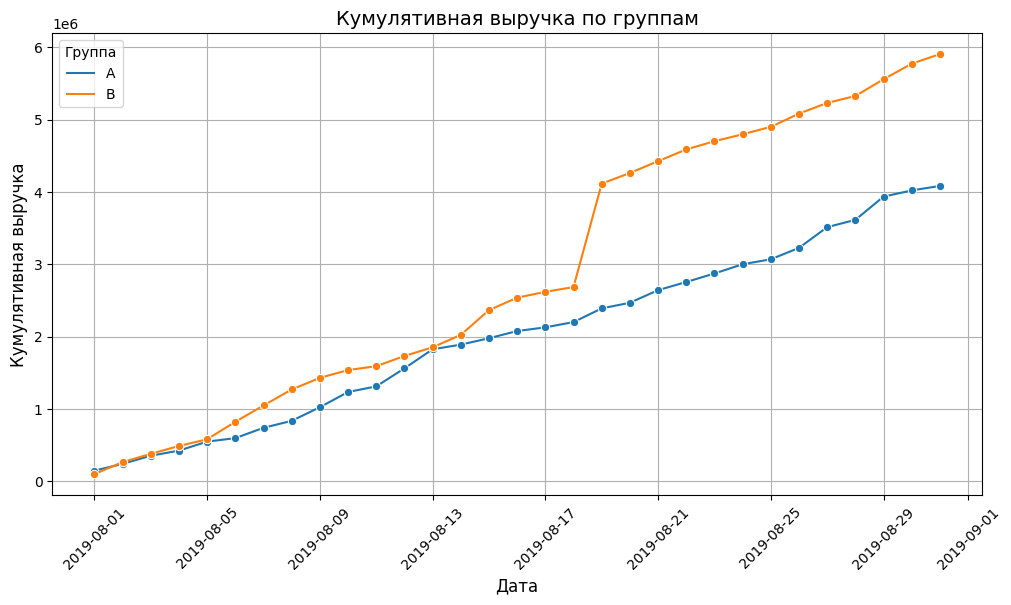

In [16]:
# Расчет кумулятивной выручки
cumulative_data = (
    orders.groupby(['date', 'group'])
    .agg({'revenue': 'sum'})
    .groupby(level=1).cumsum()
    .reset_index()
)

# Построение графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=cumulative_data, x='date', y='revenue', hue='group', marker='o')

plt.title('Кумулятивная выручка по группам', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивная выручка', fontsize=12)
plt.legend(title='Группа', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике видно, что кумулятивная выручка группы B значительно превышает выручку группы A. При этом наблюдается резкий скачок выручки группы B около середины тестового периода, что может быть связано с крупными заказами или аномалиями (например, редкие крупные покупки). Группа A демонстрирует более плавный рост выручки без явных скачков.

Предположение: необходимо дополнительно проанализировать данные на наличие аномалий в группе B, чтобы определить, являются ли эти скачки результатом естественного поведения пользователей или аномалий (например, экстремально больших заказов). Кроме того, стоит проверить распределение заказов между группами и влияние крупных покупателей на общую выручку.

### Кумулятивный средний чек по группам

Построим график кумулятивного среднего чека по группам. Сделаем выводы и предположения.

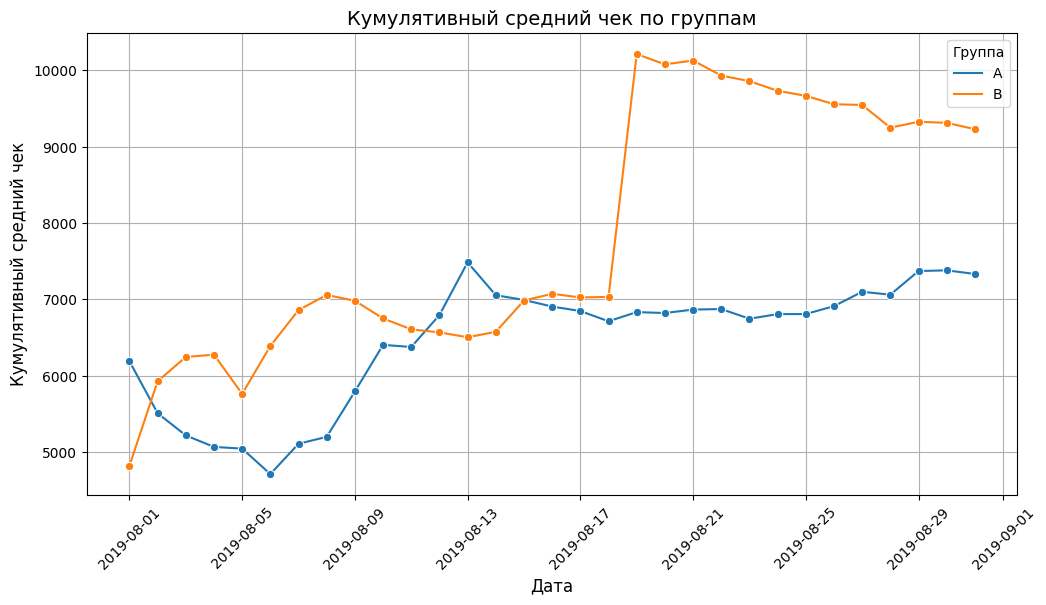

In [17]:
# Расчет кумулятивных данных
cumulative_orders = (
    orders.groupby(['date', 'group'])
    .agg({'transaction_id': 'count', 'revenue': 'sum'})
    .rename(columns={'transaction_id': 'orders'})
    .groupby(level=1).cumsum()
    .reset_index()
)

# Расчет кумулятивного среднего чека
cumulative_orders['avg_check'] = cumulative_orders['revenue'] / cumulative_orders['orders']

# Построение графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=cumulative_orders, x='date', y='avg_check', hue='group', marker='o')

plt.title('Кумулятивный средний чек по группам', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Кумулятивный средний чек', fontsize=12)
plt.legend(title='Группа', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике видно, что кумулятивный средний чек группы B выше среднего чека группы A, особенно после резкого скачка около середины тестового периода. Это может быть связано с одной или несколькими крупными покупками в группе B, которые существенно увеличили средний чек. В группе A средний чек показывает более стабильный рост без резких колебаний, с небольшой просадкой в начале периоде и дальнейшей стабилизацией на уровне ~7000. 

Предположения:
- Резкий рост среднего чека в группе B, вероятно, связан с выбросами (редкими крупными заказами), которые искажают реальную картину.
- Группе A присуща более равномерная динамика среднего чека, что может говорить о большей однородности пользователей.

### Относительное изменение кумулятивного среднего чека

Построим график относительного изменения кумулятивного среднего чека группы B к группе A. Сделаем выводы и предположения.

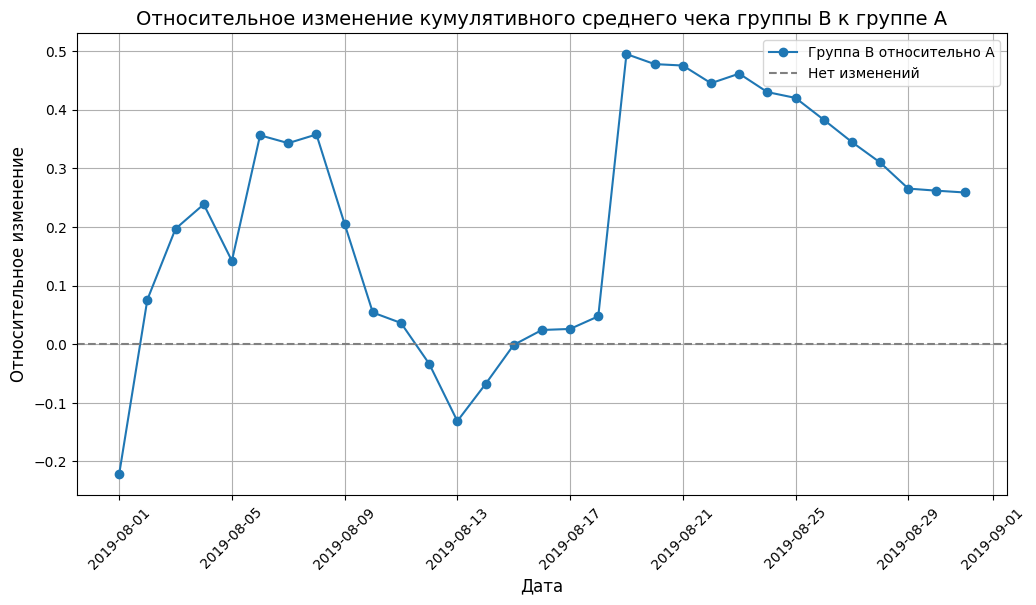

In [18]:
# Создание отдельного датафрейма для группы A
cumulative_a = cumulative_orders[cumulative_orders['group'] == 'A'][['date', 'avg_check']].rename(columns={'avg_check': 'avg_check_a'})

# Создание отдельного датафрейма для группы B
cumulative_b = cumulative_orders[cumulative_orders['group'] == 'B'][['date', 'avg_check']].rename(columns={'avg_check': 'avg_check_b'})

# Объединение данных
cumulative_relative = pd.merge(cumulative_a, cumulative_b, on='date')

# Расчет относительного изменения
cumulative_relative['relative_change'] = cumulative_relative['avg_check_b'] / cumulative_relative['avg_check_a'] - 1

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(cumulative_relative['date'], cumulative_relative['relative_change'], marker='o', label='Группа B относительно A')

plt.axhline(y=0, color='gray', linestyle='--', label='Нет изменений')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

На графике видно, что относительное изменение кумулятивного среднего чека группы B к группе A сильно колебалось на протяжении теста. В начале теста группа B немного отставала от группы A (значения ниже 0), затем демонстрировала значительный рост до 08.08.2019. На графике видно, что до пикового значения группа A некоторое время имела более высокий средний чек по сравнению с группой B (график опускается ниже нуля 13.08). Однако после этого группа B демонстрировала значительный рост, достигнув пикового значения (примерно на 50% выше группы A) в середине теста. К концу теста относительное изменение снизилось, но группа B все же осталась выше группы A.

Предположения:
- Колебания могут быть связаны с аномалиями или крупными заказами в группе B.
- Стабилизация к концу теста может говорить о том, что данные начинают отражать более реальную картину.

### Кумулятивное среднее количество заказов на посетителя по группам

Построим график кумулятивного среднего количества заказов на посетителя по группам. Сделаем выводы и предположения.

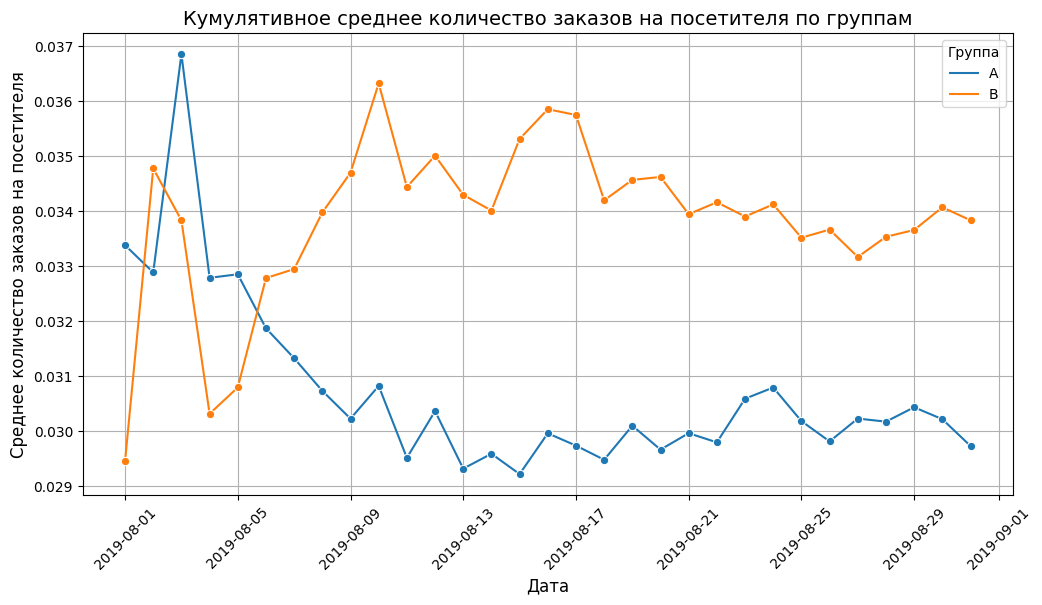

In [19]:
# Подготовка данных: кумулятивное количество заказов и посетителей
cumulative_visitors = visitors.groupby(['date', 'group']).agg({'visitors': 'sum'}).groupby(level=1).cumsum().reset_index()
cumulative_orders_visitors = pd.merge(
    cumulative_orders[['date', 'group', 'orders']],
    cumulative_visitors,
    on=['date', 'group']
)

# Расчет кумулятивного среднего количества заказов на посетителя
cumulative_orders_visitors['orders_per_visitor'] = (
    cumulative_orders_visitors['orders'] / cumulative_orders_visitors['visitors']
)

# Построение графика
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulative_orders_visitors, 
    x='date', 
    y='orders_per_visitor', 
    hue='group', 
    marker='o'
)

plt.title('Кумулятивное среднее количество заказов на посетителя по группам', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Среднее количество заказов на посетителя', fontsize=12)
plt.legend(title='Группа', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

На графике видно, что в начале теста группа A опережала группу B по среднему количеству заказов на посетителя, однако очень быстро группа B вырвалась вперед и сохраняла преимущество до конца теста. В группе A наблюдается более стабильное поведение показателя, тогда как в группе B присутствуют небольшие колебания.

Выводы и предположения:
- Группа B демонстрирует более высокую эффективность в привлечении заказов от посетителей, что может быть связано с более успешным изменением стратегии.
- Колебания в группе B могут быть вызваны влиянием отдельных пиковых дней или активностью небольшого числа пользователей.
- Группа A характеризуется более равномерным, но низким уровнем среднего количества заказов.

### Относительное изменение кумулятивного среднего количества заказов на посетителя

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделаем выводы и предположения.

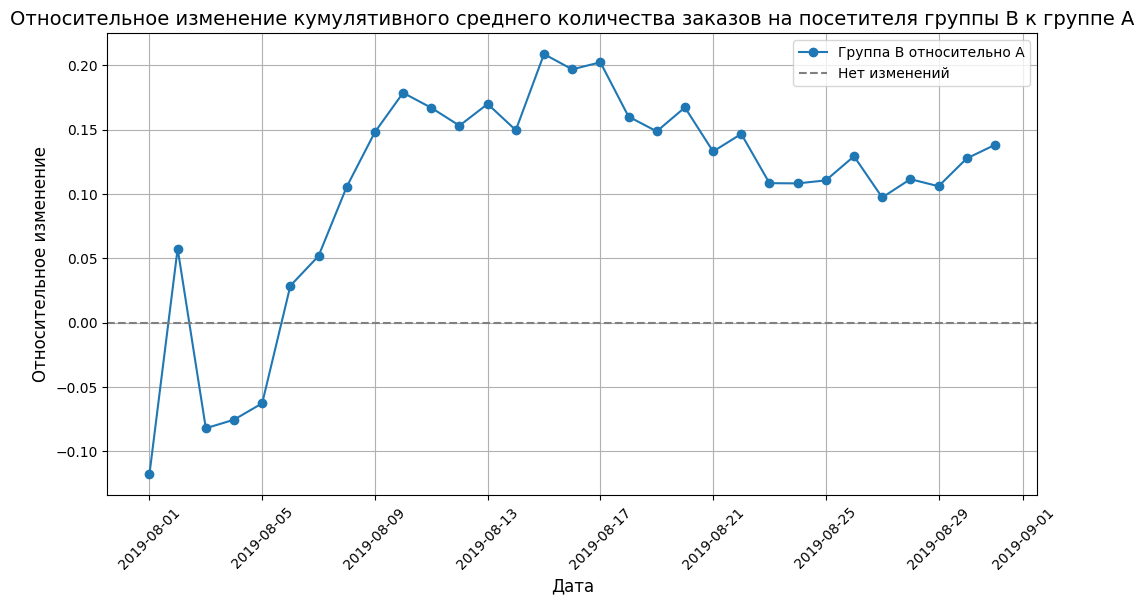

In [20]:
# Создание отдельного датафрейма для группы A
cumulative_visitors_a = cumulative_orders_visitors[cumulative_orders_visitors['group'] == 'A'][['date', 'orders_per_visitor']].rename(columns={'orders_per_visitor': 'orders_per_visitor_a'})

# Создание отдельного датафрейма для группы B
cumulative_visitors_b = cumulative_orders_visitors[cumulative_orders_visitors['group'] == 'B'][['date', 'orders_per_visitor']].rename(columns={'orders_per_visitor': 'orders_per_visitor_b'})

# Объединение данных
cumulative_relative_orders = pd.merge(cumulative_visitors_a, cumulative_visitors_b, on='date')

# Расчет относительного изменения
cumulative_relative_orders['relative_change'] = cumulative_relative_orders['orders_per_visitor_b'] / cumulative_relative_orders['orders_per_visitor_a'] - 1

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(cumulative_relative_orders['date'], cumulative_relative_orders['relative_change'], marker='o', label='Группа B относительно A')

plt.axhline(y=0, color='gray', linestyle='--', label='Нет изменений')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Относительное изменение', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

На графике видно, что, как мы уже ранее заметили, в начале теста группа B демонстрировала незначительное отставание от группы A по среднему количеству заказов на посетителя (значения ниже нуля). Однако уже после первых нескольких дней группа B начала показывать преимущество, стабильно опережая группу A до конца теста. Максимальное превышение достигало около 20%.

Выводы и предположения:
- Преимущество группы B над группой A говорит о том, что изменения, внедренные в группе B, положительно повлияли на вовлеченность пользователей в оформление заказов.
- В начале теста разница между группами могла быть вызвана случайными колебаниями или небольшой выборкой, но с увеличением объема данных результаты стабилизировались.
- Постоянное превышение показателя в группе B требует дополнительного анализа, чтобы подтвердить значимость улучшений.

### Количество заказов по пользователям

Построим точечный график количества заказов по пользователям. Сделаем выводы и предположения.

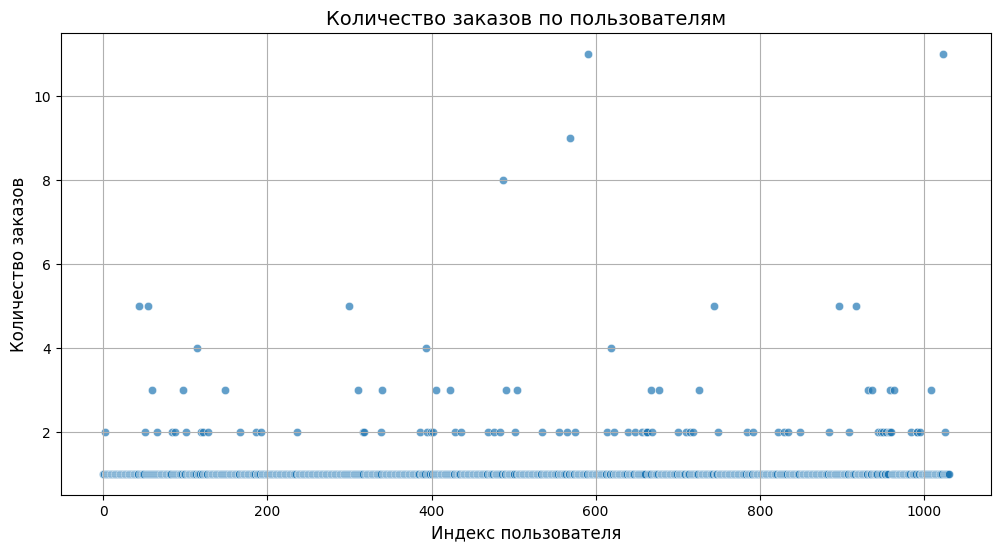

In [21]:
# Подсчет количества заказов для каждого пользователя
orders_per_user = orders.groupby('visitor_id').agg({'transaction_id': 'count'}).reset_index()
orders_per_user.columns = ['visitor_id', 'orders']

# Построение точечного графика
plt.figure(figsize=(12, 6))
sns.scatterplot(data=orders_per_user, x=range(len(orders_per_user)), y='orders', alpha=0.7)

plt.title('Количество заказов по пользователям', fontsize=14)
plt.xlabel('Индекс пользователя', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True)
plt.show()

На графике видно, что большинство пользователей совершили 1 или 2 заказа. Пользователи, сделавшие более 2 заказов, встречаются крайне редко, и их можно считать выбросами. Такие редкие значения (например, 5 или даже более 10 заказов) могут существенно влиять на средние показатели и искажать результаты анализа.

Выводы и предположения:
- Основная масса пользователей оформляет небольшое количество заказов, что соответствует обычному поведению в интернет-магазинах.
- Пользователи с большим количеством заказов могут быть либо аномалиями, либо ценным сегментом лояльных клиентов.
- Для более точного анализа стоит рассмотреть использование порогового значения (95-й или 99-й перцентили) для отсечения аномальных данных.

### 95-й и 99-й перцентили количества заказов на пользователя

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [22]:
# Распределение количества заказов на пользователя
percentile_95 = np.percentile(orders_per_user['orders'], 95)
percentile_99 = np.percentile(orders_per_user['orders'], 99)

print(f"95-й перцентиль количества заказов на пользователя: {percentile_95}")
print(f"99-й перцентиль количества заказов на пользователя: {percentile_99}")

95-й перцентиль количества заказов на пользователя: 2.0
99-й перцентиль количества заказов на пользователя: 4.0


На основе расчета:
- 95-й перцентиль показывает, что не более 5% пользователей сделали больше 2 заказов.
- 99-й перцентиль показывает, что не более 1% пользователей сделали больше 4 заказов.

Для отсечения аномальных пользователей оптимально использовать 95-й перцентиль, так как он исключает минимальное количество данных и сохраняет репрезентативность выборки. Это значит, что мы будем считать аномальными пользователей, сделавших 3 и более заказов.

### Стоимость заказов

Построим точечный график стоимостей заказов. Сделаем выводы и предположения.

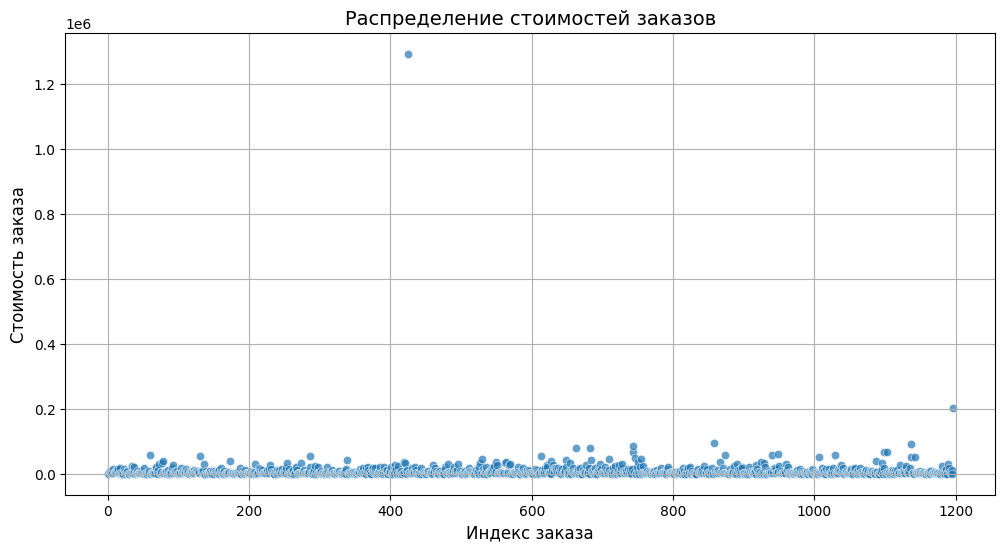

In [23]:
# Построение точечного графика стоимостей заказов
plt.figure(figsize=(12, 6))
sns.scatterplot(data=orders, x=range(len(orders)), y='revenue', alpha=0.7)

plt.title('Распределение стоимостей заказов', fontsize=14)
plt.xlabel('Индекс заказа', fontsize=12)
plt.ylabel('Стоимость заказа', fontsize=12)
plt.grid(True)
plt.show()

На графике видно, что большинство заказов имеют сравнительно низкую стоимость, распределенную в достаточно узком диапазоне, но при этом наблюдаются явные выбросы с очень высокими значениями. Один из заказов превышает 1.2 млн, что значительно выбивается из общего диапазона и может существенно искажать средние показатели.

Выводы и предположения:
- Большая часть заказов относится к относительно низкому ценовому сегменту, что характерно для большинства интернет-магазинов.
- Высокие значения (выше 200 тыс. и особенно более 1 млн) являются выбросами. Они могут быть вызваны редкими крупными покупками или ошибками в данных.
- Такие выбросы могут значительно влиять на расчет среднего чека, особенно в группе, где они находятся.

### 95-й и 99-й перцентили стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [24]:
# Расчет перцентилей стоимости заказов
revenue_percentile_95 = np.percentile(orders['revenue'], 95)
revenue_percentile_99 = np.percentile(orders['revenue'], 99)

print(f"95-й перцентиль стоимости заказов: {revenue_percentile_95}")
print(f"99-й перцентиль стоимости заказов: {revenue_percentile_99}")

95-й перцентиль стоимости заказов: 28000.000000000004
99-й перцентиль стоимости заказов: 58233.19999999999


На основе расчетов:
- 95-й перцентиль показывает, что не более 5% заказов имеют стоимость выше 28,000.
- 99-й перцентиль показывает, что не более 1% заказов имеют стоимость выше 58,233.

Для отсечения аномальных заказов оптимально использовать 95-й перцентиль (28,000), так как это исключит минимальное количество данных и сохранит репрезентативность выборки. Заказы с большей стоимостью могут рассматриваться как выбросы, особенно учитывая их редкость.

### Различия в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделаем выводы и предположения.

In [25]:
# Уровень значимости
alpha = 0.05

# Подготовка данных
orders_by_users_a = orders[orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'count'})
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = orders[orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'count'})
orders_by_users_b.columns = ['visitor_id', 'orders']

# Добавляем пользователей без заказов (совершили 0 заказов)
sample_a = pd.concat([orders_by_users_a['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_users_a)))], ignore_index=True)
sample_b = pd.concat([orders_by_users_b['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_users_b)))], ignore_index=True)

# Критерий Манна-Уитни
test_result = mannwhitneyu(sample_a, sample_b, alternative="two-sided")
p_value = test_result.pvalue
relative_difference = (sample_b.mean() - sample_a.mean()) / sample_a.mean()

# Вывод результатов
print(f"p-value: {p_value:.5f}")
print(f"Относительное различие: {relative_difference:.3f}")

if p_value < alpha:
    print(f"Различие статистически значимо при уровне значимости {alpha}.")
else:
    print(f"Различие не является статистически значимым при уровне значимости {alpha}.")

p-value: 0.01679
Относительное различие: 0.138
Различие статистически значимо при уровне значимости 0.05.


Выводы:
1. P-value составляет 0.01679, что меньше уровня значимости 0.05. Это означает, что различие в среднем количестве заказов на посетителя между группами A и B является статистически значимым.
2. Группа B показывает на 13.8% большее среднее количество заказов на посетителя по сравнению с группой A.

Предположения:
- Статистически значимое различие указывает на то, что изменения, внедренные в группе B, положительно влияют на поведение пользователей, увеличивая среднее количество заказов.
- Однако следует учитывать, что данные пока не очищены от аномалий, и высокие показатели могут быть вызваны выбросами.

### Различия в среднем чеке заказа между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделаем выводы и предположения.

In [26]:
# Критерий Манна-Уитни для среднего чека
test_result_revenue = mannwhitneyu(
    orders[orders['group'] == 'A']['revenue'], 
    orders[orders['group'] == 'B']['revenue'], 
    alternative="two-sided"
)

p_value_revenue = test_result_revenue.pvalue
relative_difference_revenue = (
    orders[orders['group'] == 'B']['revenue'].mean() - orders[orders['group'] == 'A']['revenue'].mean()
) / orders[orders['group'] == 'A']['revenue'].mean()

# Уровень значимости
alpha = 0.05

# Вывод результатов
print(f"p-value: {p_value_revenue:.5f}")
print(f"Относительное различие: {relative_difference_revenue:.3f}")

if p_value_revenue < alpha:
    print(f"Различие в среднем чеке статистически значимо при уровне значимости {alpha}.")
else:
    print(f"Различие в среднем чеке не является статистически значимым при уровне значимости {alpha}.")

p-value: 0.72929
Относительное различие: 0.259
Различие в среднем чеке не является статистически значимым при уровне значимости 0.05.


Выводы:
1. p-value составляет 0.72929, что больше уровня значимости 0.05. Это означает, что различие в среднем чеке между группами A и B не является статистически значимым.
2. Мы не можем отвергнуть нулевую гипотезу о том, что средние чеки в группах одинаковы.
3. Средний чек группы B на 25.9% больше, чем у группы A, но это различие не может быть признано значимым из-за большого p-value.

Предположения:
- Хотя средний чек группы B визуально выше, это различие может быть вызвано выбросами (очень крупными заказами), которые существенно увеличивают среднее значение.
- Отсутствие статистической значимости указывает на то, что, вероятно, изменения в группе B не оказали влияния на средний чек.

### Различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделаем выводы и предположения.

In [27]:
# Расчет перцентилей для автоматической фильтрации
orders_threshold = np.percentile(orders_per_user['orders'], 95)  # 95-й перцентиль количества заказов
revenue_threshold = np.percentile(orders['revenue'], 95)  # 95-й перцентиль стоимости заказов

# Определение аномальных пользователей
users_with_many_orders = orders.groupby('visitor_id').agg({'transaction_id': 'count'}).query(f'transaction_id >= {orders_threshold}').index
users_with_expensive_orders = orders.query(f'revenue > {revenue_threshold}')['visitor_id'].unique()
abnormal_users = set(users_with_many_orders).union(users_with_expensive_orders)

# Исключение аномальных пользователей из данных
filtered_orders = orders[~orders['visitor_id'].isin(abnormal_users)]

In [28]:
# Подготовка данных для анализа
filtered_orders_by_users_a = filtered_orders[filtered_orders['group'] == 'A'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'count'})
filtered_orders_by_users_a.columns = ['visitor_id', 'orders']

filtered_orders_by_users_b = filtered_orders[filtered_orders['group'] == 'B'].groupby('visitor_id', as_index=False).agg({'transaction_id': 'count'})
filtered_orders_by_users_b.columns = ['visitor_id', 'orders']

# Добавление пользователей без заказов
filtered_sample_a = pd.concat([filtered_orders_by_users_a['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(filtered_orders_by_users_a)))], ignore_index=True)
filtered_sample_b = pd.concat([filtered_orders_by_users_b['orders'], pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(filtered_orders_by_users_b)))], ignore_index=True)

# Критерий Манна-Уитни для очищенных данных
test_result_filtered = mannwhitneyu(filtered_sample_a, filtered_sample_b, alternative="two-sided")
p_value_filtered = test_result_filtered.pvalue
relative_difference_filtered = (filtered_sample_b.mean() - filtered_sample_a.mean()) / filtered_sample_a.mean()

# Уровень значимости
alpha = 0.05

# Вывод результатов
print(f"p-value: {p_value_filtered:.5f}")
print(f"Относительное различие: {relative_difference_filtered:.3f}")

if p_value_filtered < alpha:
    print(f"Различие в среднем количестве заказов статистически значимо при уровне значимости {alpha}.")
else:
    print(f"Различие в среднем количестве заказов не является статистически значимым при уровне значимости {alpha}.")

p-value: 0.01236
Относительное различие: 0.181
Различие в среднем количестве заказов статистически значимо при уровне значимости 0.05.


Выводы:
1. P-value составляет 0.01236, что меньше уровня значимости 0.05. Это указывает на то, что различие в среднем количестве заказов на посетителя между группами A и B по очищенным данным является статистически значимым.
2. Среднее количество заказов на посетителя в группе B на 18.1% выше, чем в группе A. Это говорит о том, что изменения, внедренные в группе B, действительно оказывают положительное влияние на количество заказов.

Предположения:
- После фильтрации аномальных пользователей разница между группами осталась статистически значимой, что подтверждает положительный эффект изменений в группе B.
- Очистка данных позволила исключить влияние выбросов, что сделало результаты более надежными и точными.

### Различия в среднем чеке заказа между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделаем выводы и предположения.

In [29]:
# Критерий Манна-Уитни для среднего чека по очищенным данным
test_result_revenue_filtered = mannwhitneyu(
    filtered_orders[filtered_orders['group'] == 'A']['revenue'], 
    filtered_orders[filtered_orders['group'] == 'B']['revenue'], 
    alternative="two-sided"
)

p_value_revenue_filtered = test_result_revenue_filtered.pvalue
relative_difference_revenue_filtered = (
    filtered_orders[filtered_orders['group'] == 'B']['revenue'].mean() - 
    filtered_orders[filtered_orders['group'] == 'A']['revenue'].mean()
) / filtered_orders[filtered_orders['group'] == 'A']['revenue'].mean()

# Уровень значимости
alpha = 0.05

# Вывод результатов
print(f"p-value: {p_value_revenue_filtered:.5f}")
print(f"Относительное различие: {relative_difference_revenue_filtered:.3f}")

if p_value_revenue_filtered < alpha:
    print(f"Различие в среднем чеке статистически значимо при уровне значимости {alpha}.")
else:
    print(f"Различие в среднем чеке не является статистически значимым при уровне значимости {alpha}.")

p-value: 0.85100
Относительное различие: -0.006
Различие в среднем чеке не является статистически значимым при уровне значимости 0.05.


Выводы:
1. P-value составляет 0.85100, что больше уровня значимости 0.05. Это указывает на отсутствие статистически значимых различий в среднем чеке заказа между группами A и B по очищенным данным.
2. Нулевую гипотезу о равенстве среднего чека между группами нельзя отвергнуть.
3. Средний чек группы B оказался на 0.6% ниже, чем в группе A, но это различие настолько мало, что, вероятно, является результатом случайных колебаний.

Предположения:
- После удаления аномально дорогих заказов влияние выбросов на данные исчезло, и различия между группами оказались практически незаметными.
- Это подтверждает, что изменения в группе B не повлияли на средний чек заказов.

### Решение по результатам теста

Примем решение по результатам теста и объясним его. Варианты решений:
1. Остановить тест, зафиксировать победу одной из групп.
2. Остановить тест, зафиксировать отсутствие различий между группами.
3. Продолжить тест.

Мы принимаем решение остановить тест и зафиксировать победу группы B. Это основано на том, что группа B показывает статистически значимое увеличение среднего количества заказов на посетителя на 18.1% (p-value = 0.01236) по сравнению с группой A. Это ключевой показатель, демонстрирующий положительное влияние изменений в группе B.

Различия в среднем чеке заказа между группами не являются статистически значимыми (p-value = 0.85100). Однако это не влияет на общее решение, так как увеличение количества заказов при неизменном среднем чеке приводит к росту выручки. После удаления аномалий различия в среднем количестве заказов остались статистически значимыми, что подтверждает надежность результата.

Продолжение теста нецелесообразно, так как статистическая значимость уже достигнута, и дополнительные данные вряд ли изменят выводы. Мы рекомендуем зафиксировать победу группы B и масштабировать изменения на всю аудиторию, так как они положительно влияют на ключевые показатели бизнеса.

## Заключение и выводы

Таким образом, была выполнена работа в качестве аналитика крупного интернет-магазина. Мы провели приоритизацию гипотез с использованием фреймворков ICE и RICE. Учет охвата (Reach) в формуле RICE позволил определить более масштабные гипотезы как приоритетные. В результате лидером стала гипотеза о добавлении формы подписки, которая охватывает широкую аудиторию.

Анализ A/B-теста показал, что группа B опережает группу A по количеству заказов и демонстрирует положительную динамику. Средний чек группы B был выше, но имел сильные выбросы. После анализа распределения заказов и их стоимости были выявлены аномальные пользователи, что позволило исключить их для повышения точности теста.

Статистический анализ показал, что по сырым данным группа B увеличила среднее количество заказов на посетителя на 13.8%. После очистки данных результаты остались статистически значимыми, и группа B показала прирост в 18.1%. Различия в среднем чеке между группами не являются статистически значимыми, что подтверждает стабильность этого показателя.

На основе результатов теста принято решение зафиксировать победу группы B. Изменения, внедренные в этой группе, положительно влияют на количество заказов, что способствует увеличению выручки. Рекомендуется масштабировать изменения на всю аудиторию. Это подтверждает, что систематический подход к приоритизации гипотез и анализу A/B-тестов позволяет принимать обоснованные решения для роста ключевых бизнес-показателей.